In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline

In [2]:
conditions = pd.read_csv("../../100k_synthea_covid19_csv/conditions.csv")
patients = pd.read_csv("../../100k_synthea_covid19_csv/patients.csv")

In [3]:
### Data Pre-processing ###
print(conditions.shape)
conditions.head(5)

(1143900, 6)


,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION
0,2019-02-15,2019-08-01,1ff7f10f-a204-4bb1-aa72-dd763fa99482,d317dacb-d801-4136-be7d-440094f7ae83,65363002,Otitis media
1,2019-10-30,2020-01-30,1ff7f10f-a204-4bb1-aa72-dd763fa99482,759cfd9c-b40b-45df-a5b2-fca418027a6a,65363002,Otitis media
2,2020-03-01,2020-03-30,1ff7f10f-a204-4bb1-aa72-dd763fa99482,60584c6a-e26b-4176-a660-86ad84c7ceca,386661006,Fever (finding)
3,2020-03-01,2020-03-01,1ff7f10f-a204-4bb1-aa72-dd763fa99482,60584c6a-e26b-4176-a660-86ad84c7ceca,840544004,Suspected COVID-19
4,2020-03-01,2020-03-30,1ff7f10f-a204-4bb1-aa72-dd763fa99482,60584c6a-e26b-4176-a660-86ad84c7ceca,840539006,COVID-19


In [4]:
print(patients.shape)
pd.set_option('display.max_columns', None)
patients.head()

(124150, 25)


,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,LAST,SUFFIX,MAIDEN,MARITAL,RACE,ETHNICITY,GENDER,BIRTHPLACE,ADDRESS,CITY,STATE,COUNTY,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,2017-08-24,NaN,999-68-6630,NaN,NaN,NaN,Jacinto644,Kris249,NaN,NaN,NaN,white,nonhispanic,M,Beverly Massachusetts US,888 Hickle Ferry Suite 38,Springfield,Massachusetts,Hampden County,1106.0,42.151961,-72.598959,8446.49,1499.08
1,9bcf6ed5-d808-44af-98a0-7d78a29ede72,2016-08-01,NaN,999-15-5895,NaN,NaN,NaN,Alva958,Krajcik437,NaN,NaN,NaN,white,nonhispanic,F,Boston Massachusetts US,1048 Skiles Trailer,Walpole,Massachusetts,Norfolk County,2081.0,42.177370,-71.281353,94568.40,1870.72
2,5163c501-353c-4a82-b863-a3f1df2d6cf1,2004-01-09,NaN,999-73-2461,S99999063,NaN,NaN,Jimmie93,Harris789,NaN,NaN,NaN,white,nonhispanic,F,Worcester Massachusetts US,201 Mitchell Lodge Unit 67,Pembroke,Massachusetts,Plymouth County,NaN,42.075292,-70.757035,375754.62,3131.44
3,cc3c806f-4a09-4a89-a990-4286450956be,1996-11-15,NaN,999-60-7372,S99924941,X9952947X,Mr.,Gregorio366,Auer97,NaN,NaN,NaN,white,nonhispanic,M,Patras Achaea GR,1050 Lindgren Extension Apt 38,Boston,Massachusetts,Suffolk County,2135.0,42.352434,-71.028610,484758.46,3632.96
4,bd1c4ffc-7f1d-4590-adbb-1d6533fb623e,2019-06-12,NaN,999-81-4349,NaN,NaN,NaN,Karyn217,Mueller846,NaN,NaN,NaN,white,nonhispanic,F,New Bedford Massachusetts US,570 Abshire Forge Suite 32,Colrain,Massachusetts,Franklin County,NaN,42.740220,-72.722648,24130.00,903.28


In [5]:
# IDs of patients that have been diagnosed with COVID-19
covid_patient_ids = conditions[conditions.CODE == 840539006].PATIENT.unique()

In [6]:
# All conditions for patients who got COVID
conditions_covid = conditions[conditions['PATIENT'].isin(covid_patient_ids)]

In [7]:
# Create new dataframe for the numbers of all conditions for covid patients
value_counts_result = conditions_covid['DESCRIPTION'].value_counts()
covid_conditions = value_counts_result.reset_index()
covid_conditions.columns = ['DESCRIPTION', '# of Patients']

In [8]:
# Delete COVID-19 and Suspected COVID-19 rows
covid_conditions = covid_conditions[covid_conditions['DESCRIPTION'] != 'COVID-19']
covid_conditions = covid_conditions[covid_conditions['DESCRIPTION'] != 'Suspected COVID-19']
covid_conditions.reset_index(drop=True, inplace=True)

In [9]:
covid_conditions.head(10)

,DESCRIPTION,# of Patients
0,Fever (finding),78341
1,Cough (finding),59766
2,Loss of taste (finding),44646
3,Body mass index 30+ - obesity (finding),33903
4,Fatigue (finding),33855
5,Sputum finding (finding),29666
6,Prediabetes,25442
7,Hypertension,23019
8,Anemia (disorder),22803
9,Pneumonia (disorder),18175


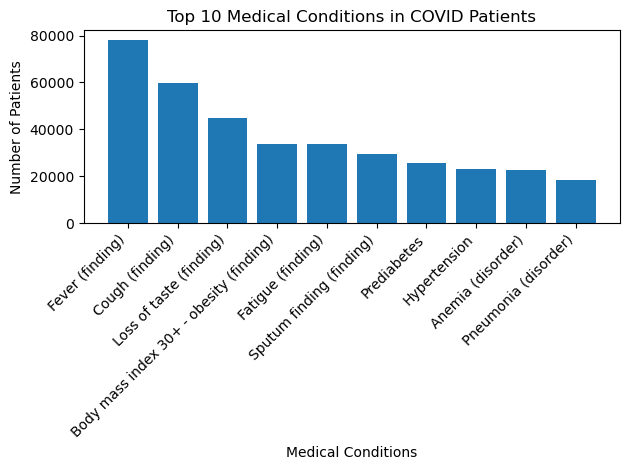

In [10]:
# Plotting the histogram
plt.bar(covid_conditions["DESCRIPTION"].head(10), covid_conditions["# of Patients"].head(10))
plt.xlabel('Medical Conditions')
plt.ylabel('Number of Patients')
plt.title('Top 10 Medical Conditions in COVID Patients')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()

# Show the plot
plt.show()

In [11]:
# Create a new dataframe that includes dummy variables to determine the patient experience the medical conditions
conditions2 = conditions.copy()
conditions_dummy = pd.get_dummies(conditions2['DESCRIPTION'].str.lower())
conditions_dummy = conditions_dummy.drop(columns=['covid-19','suspected covid-19'])
conditions2 = conditions2.drop(columns=['START','STOP','DESCRIPTION','ENCOUNTER','CODE'])
conditions2['COVID'] = (conditions['PATIENT'].isin(covid_patient_ids)).astype(int)
conditions3 = pd.concat([conditions2, conditions_dummy], axis=1)

In [12]:
# Make all conditions for one patient into one column 
column_name = 'COVID'
start_index = conditions3.columns.get_loc(column_name) + 1 
conditions3 = conditions3.groupby('PATIENT').agg(lambda x: max(x) if x.name in conditions3.columns[start_index:] else x.iloc[0])
conditions3.reset_index(inplace=True)
conditions3.head()

/var/folders/h7/0x3bb9dj4cs4dy4xvwqx7xpr0000gn/T/ipykernel_77388/1677337214.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  conditions3.reset_index(inplace=True)


,PATIENT,COVID,acquired coagulation disorder (disorder),acute allergic reaction,acute bacterial sinusitis (disorder),acute bronchitis (disorder),acute cholecystitis,acute deep venous thrombosis (disorder),acute pulmonary embolism (disorder),acute respiratory distress syndrome (disorder),acute respiratory failure (disorder),acute viral pharyngitis (disorder),alcoholism,alzheimer's disease (disorder),anemia (disorder),antepartum eclampsia,appendicitis,asthma,at risk for suicide (finding),atopic dermatitis,atrial fibrillation,attempted suicide - cut/stab,bacterial infectious disease (disorder),bleeding from anus,blighted ovum,blindness due to type 2 diabetes mellitus (disorder),body mass index 30+ - obesity (finding),body mass index 40+ - severely obese (finding),brain damage - traumatic,bullet wound,burn injury(morphologic abnormality),carcinoma in situ of prostate (disorder),cardiac arrest,child attention deficit disorder,childhood asthma,chill (finding),cholelithiasis,chronic congestive heart failure (disorder),chronic intractable migraine without aura,chronic kidney disease stage 1 (disorder),chronic kidney disease stage 2 (disorder),chronic kidney disease stage 3 (disorder),chronic obstructive bronchitis (disorder),chronic pain,chronic paralysis due to lesion of spinal cord,chronic sinusitis (disorder),closed fracture of hip,concussion injury of brain,concussion with loss of consciousness,concussion with no loss of consciousness,contact dermatitis,coronary heart disease,cough (finding),cystic fibrosis,cystitis,diabetes,diabetes from cystic fibrosis,diabetic renal disease (disorder),diabetic retinopathy associated with type ii diabetes mellitus (disorder),diarrhea symptom (finding),drug overdose,dyspnea (finding),epilepsy,escherichia coli urinary tract infection,facial laceration,familial alzheimer's disease of early onset (disorder),fatigue (finding),female infertility,fetus with unknown complication,fever (finding),first degree burn,fracture of ankle,fracture of clavicle,fracture of forearm,fracture of rib,fracture of the vertebral column with spinal cord injury,fracture of vertebral column without spinal cord injury,fracture subluxation of wrist,gout,headache (finding),heart failure (disorder),hemoptysis (finding),history of amputation of foot (situation),history of appendectomy,history of cardiac arrest (situation),history of disarticulation at wrist (situation),history of lower limb amputation (situation),history of myocardial infarction (situation),history of single seizure (situation),history of upper limb amputation (situation),hyperglycemia (disorder),hyperlipidemia,hypertension,hypertriglyceridemia (disorder),hypoxemia (disorder),idiopathic atrophic hypothyroidism,impacted molars,infection caused by pseudomonas aeruginosa,infection caused by staphylococcus aureus,injury of anterior cruciate ligament,injury of heart (disorder),injury of kidney (disorder),injury of medial collateral ligament of knee,injury of tendon of the rotator cuff of shoulder,joint pain (finding),laceration of foot,laceration of forearm,laceration of hand,laceration of thigh,localized primary osteoarthritis of the hand,loss of taste (finding),lupus erythematosus,macular edema and retinopathy due to type 2 diabetes mellitus (disorder),major depression single episode,major depression disorder,male infertility,malignant neoplasm of breast (disorder),malignant tumor of colon,meconium ileus,metabolic syndrome x (disorder),metastasis from malignant tumor of prostate (disorder),microalbuminuria due to type 2 diabetes mellitus (disorder),miscarriage in first trimester,muscle pain (finding),myocardial infarction,nasal congestion (finding),nausea (finding),neoplasm of prostate,neuropathy due to type 2 diabetes mellitus (disorder),non-low risk pregnancy,non-small cell carcinoma of lung tnm stage 1 (disorder),non-small cell lung cancer (disorder),nonproliferative diabetic retinopathy due to type 2 diabetes mellitus (disorder),normal pregnancy,opioid abuse (d

In [13]:
# Drop PATIENT column
conditions3 = conditions3.drop(columns=['PATIENT'])

In [14]:
conditions3.head()

,COVID,acquired coagulation disorder (disorder),acute allergic reaction,acute bacterial sinusitis (disorder),acute bronchitis (disorder),acute cholecystitis,acute deep venous thrombosis (disorder),acute pulmonary embolism (disorder),acute respiratory distress syndrome (disorder),acute respiratory failure (disorder),acute viral pharyngitis (disorder),alcoholism,alzheimer's disease (disorder),anemia (disorder),antepartum eclampsia,appendicitis,asthma,at risk for suicide (finding),atopic dermatitis,atrial fibrillation,attempted suicide - cut/stab,bacterial infectious disease (disorder),bleeding from anus,blighted ovum,blindness due to type 2 diabetes mellitus (disorder),body mass index 30+ - obesity (finding),body mass index 40+ - severely obese (finding),brain damage - traumatic,bullet wound,burn injury(morphologic abnormality),carcinoma in situ of prostate (disorder),cardiac arrest,child attention deficit disorder,childhood asthma,chill (finding),cholelithiasis,chronic congestive heart failure (disorder),chronic intractable migraine without aura,chronic kidney disease stage 1 (disorder),chronic kidney disease stage 2 (disorder),chronic kidney disease stage 3 (disorder),chronic obstructive bronchitis (disorder),chronic pain,chronic paralysis due to lesion of spinal cord,chronic sinusitis (disorder),closed fracture of hip,concussion injury of brain,concussion with loss of consciousness,concussion with no loss of consciousness,contact dermatitis,coronary heart disease,cough (finding),cystic fibrosis,cystitis,diabetes,diabetes from cystic fibrosis,diabetic renal disease (disorder),diabetic retinopathy associated with type ii diabetes mellitus (disorder),diarrhea symptom (finding),drug overdose,dyspnea (finding),epilepsy,escherichia coli urinary tract infection,facial laceration,familial alzheimer's disease of early onset (disorder),fatigue (finding),female infertility,fetus with unknown complication,fever (finding),first degree burn,fracture of ankle,fracture of clavicle,fracture of forearm,fracture of rib,fracture of the vertebral column with spinal cord injury,fracture of vertebral column without spinal cord injury,fracture subluxation of wrist,gout,headache (finding),heart failure (disorder),hemoptysis (finding),history of amputation of foot (situation),history of appendectomy,history of cardiac arrest (situation),history of disarticulation at wrist (situation),history of lower limb amputation (situation),history of myocardial infarction (situation),history of single seizure (situation),history of upper limb amputation (situation),hyperglycemia (disorder),hyperlipidemia,hypertension,hypertriglyceridemia (disorder),hypoxemia (disorder),idiopathic atrophic hypothyroidism,impacted molars,infection caused by pseudomonas aeruginosa,infection caused by staphylococcus aureus,injury of anterior cruciate ligament,injury of heart (disorder),injury of kidney (disorder),injury of medial collateral ligament of knee,injury of tendon of the rotator cuff of shoulder,joint pain (finding),laceration of foot,laceration of forearm,laceration of hand,laceration of thigh,localized primary osteoarthritis of the hand,loss of taste (finding),lupus erythematosus,macular edema and retinopathy due to type 2 diabetes mellitus (disorder),major depression single episode,major depression disorder,male infertility,malignant neoplasm of breast (disorder),malignant tumor of colon,meconium ileus,metabolic syndrome x (disorder),metastasis from malignant tumor of prostate (disorder),microalbuminuria due to type 2 diabetes mellitus (disorder),miscarriage in first trimester,muscle pain (finding),myocardial infarction,nasal congestion (finding),nausea (finding),neoplasm of prostate,neuropathy due to type 2 diabetes mellitus (disorder),non-low risk pregnancy,non-small cell carcinoma of lung tnm stage 1 (disorder),non-small cell lung cancer (disorder),nonproliferative diabetic retinopathy due to type 2 diabetes mellitus (disorder),normal pregnancy,opioid abuse (disorder)

<Axes: >

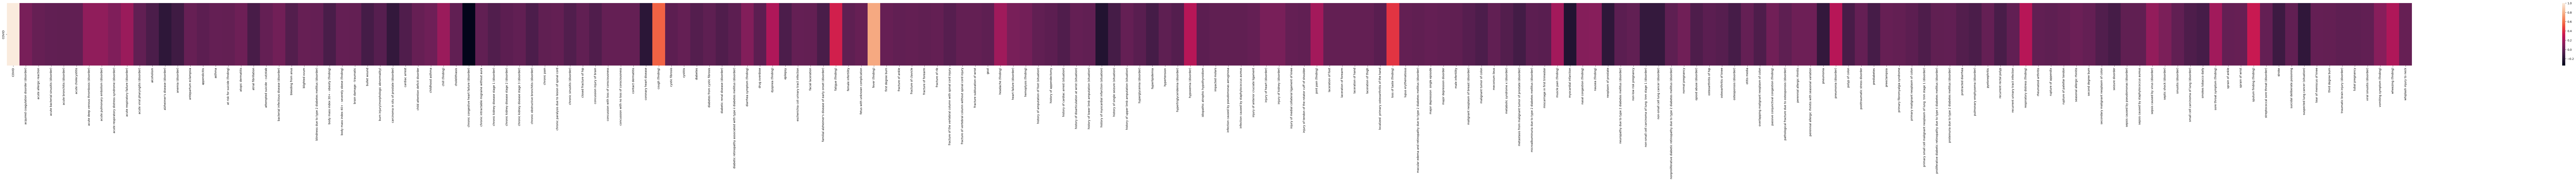

In [15]:
# See correletion
import seaborn as sns
plt.figure(figsize=(191,4))
sns.heatmap(conditions3.corr().loc[['COVID'],:])

In [16]:
# Calculate the number of rows for 20% of the data
percentage = 0.2
sample_size = int(len(conditions3) * percentage)

# Separate 20% of the data
test_conditions = conditions3.sample(n=sample_size, random_state=42) # 20% for test
remaining_conditions = conditions3.loc[~conditions3.index.isin(test_conditions.index)] # 80% for fit

In [17]:
# Separate 20% of data to X_test, Y_test
Y_test = test_conditions.COVID.values
test_conditions = test_conditions.drop(columns=['COVID'])
X_test = test_conditions.values
print(Y_test.shape)
print(X_test.shape)

(24439,)
(24439, 189)


In [18]:
# Separate 80& of data to xtrain, ytrain
ytrain = remaining_conditions.COVID.values
remaining_conditions = remaining_conditions.drop(columns=['COVID'])
xtrain = remaining_conditions.values
print(ytrain.shape)
print(xtrain.shape)

(97759,)
(97759, 189)


In [19]:
### Decesion Tree with grid search the best hyperparameters ###
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

param_grid_dt = {
    'max_depth': [1, 2, 5, 25],          
    'max_leaf_nodes': [5, 10, 15, 25]    
}

dtree = DecisionTreeClassifier(random_state=30, criterion='entropy')
grid_search_dt = GridSearchCV(dtree, param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_dt.fit(xtrain, ytrain)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=30),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 5, 25],
                         'max_leaf_nodes': [5, 10, 15, 25]},
             scoring='accuracy')

In [20]:
# Get the best hyperparameters
best_params_dt = grid_search_dt.best_params_
print("Best Hyperparameters:", best_params_dt)

Best Hyperparameters: {'max_depth': 25, 'max_leaf_nodes': 25}


In [21]:
# Get the best model
best_model_dt = grid_search_dt.best_estimator_

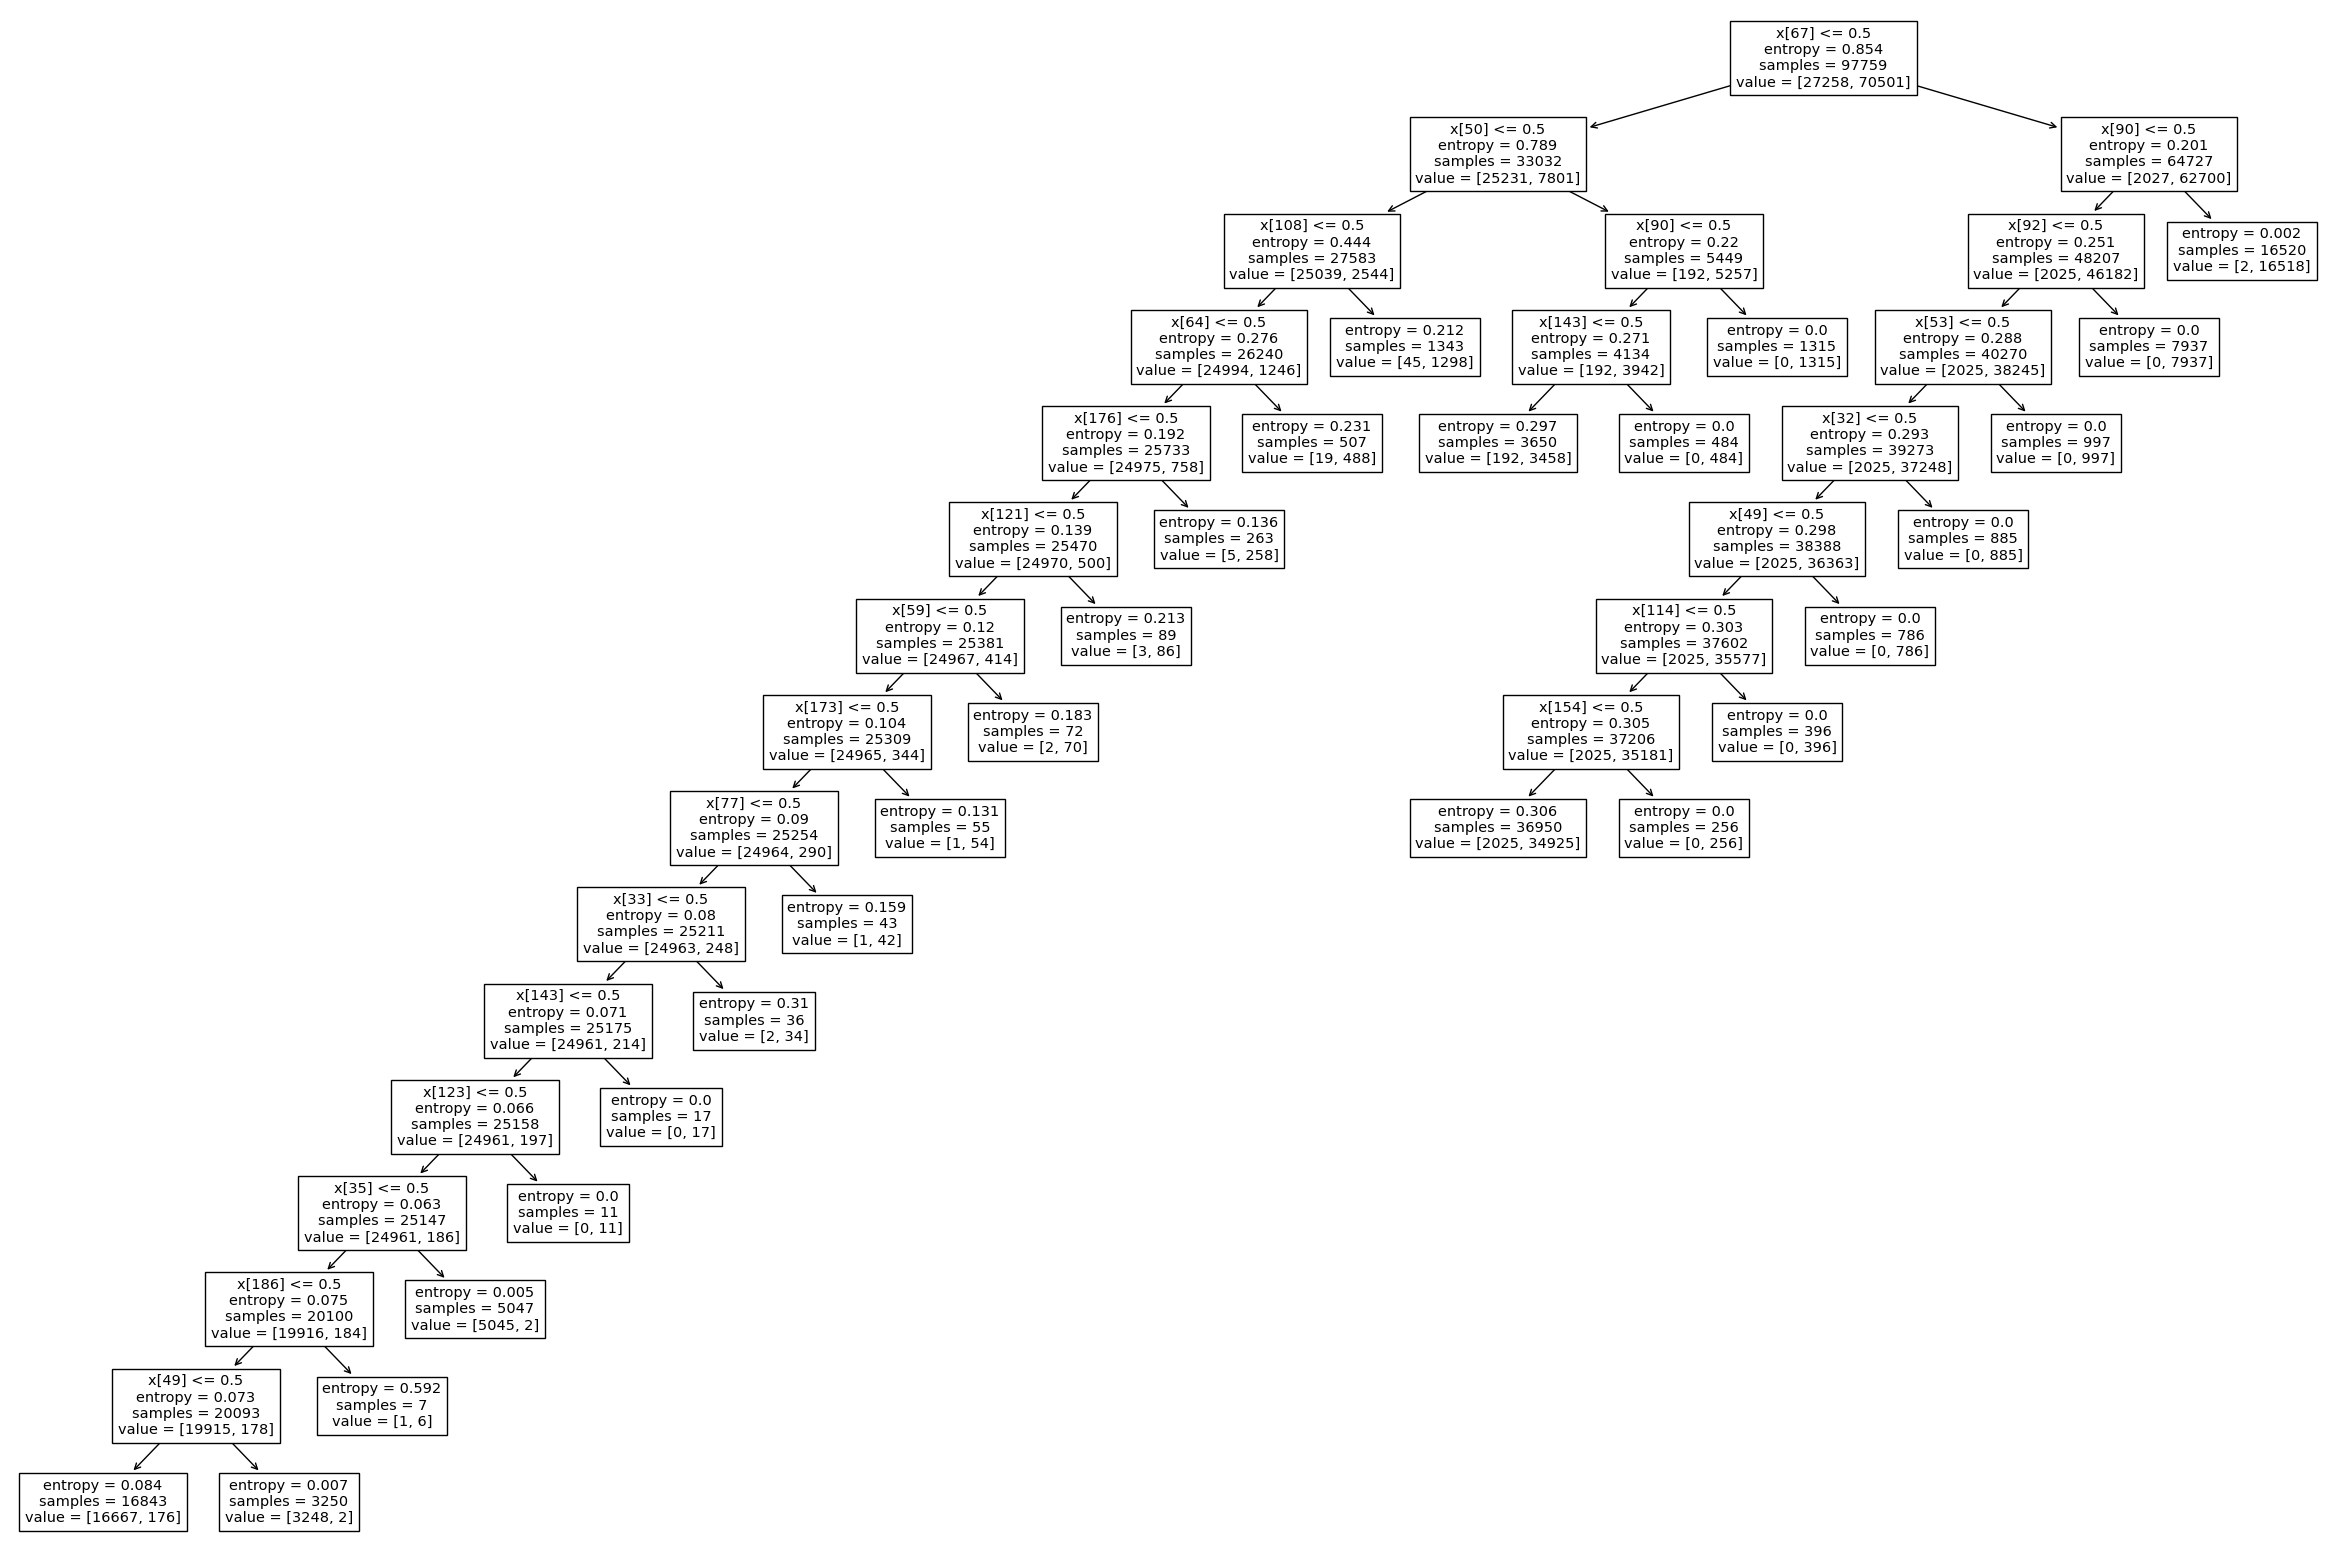

In [22]:
from sklearn import tree
plt.figure(figsize=(30, 20))
tree.plot_tree(best_model_dt)
plt.show()

In [44]:
# Make predictions on the test set
ypred = best_model_dt.predict(X_test)

# Calculate and print Mean Squared Error and Accuracy
from sklearn.metrics import accuracy_score

mse_dtree = mean_squared_error(Y_test, ypred)
accuracy_dtree = accuracy_score(Y_test, ypred)

print(f"Mean Squared Error: {mse_dtree}")
print(f"Accuracy: {accuracy_dtree}")

Mean Squared Error: 0.024878268341585172
Accuracy: 0.9751217316584149


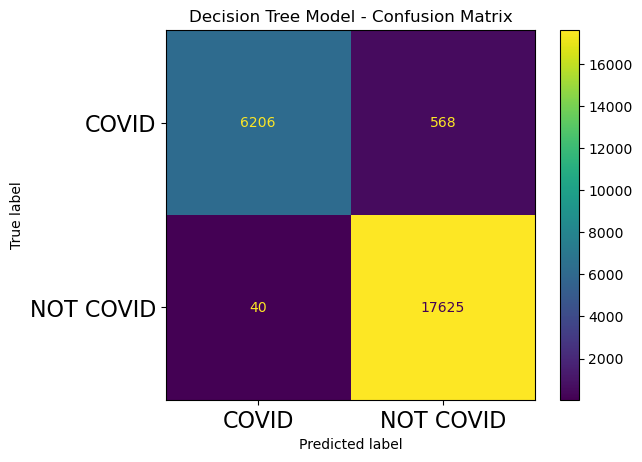

In [24]:
# Confusion Metrix for Decision Tree
from sklearn.metrics import ConfusionMatrixDisplay
cm = ConfusionMatrixDisplay.from_estimator(best_model_dt, X_test, Y_test)

plt.title("Decision Tree Model - Confusion Matrix")
plt.xticks(range(2), ["COVID","NOT COVID"], fontsize=16)
plt.yticks(range(2), ["COVID","NOT COVID"], fontsize=16)
plt.show()

In [1]:
# Function to conpute precision and recall
def calculate_precision(true_positives, false_positives):
    return true_positives / (true_positives + false_positives)

def calculate_recall(true_positives, false_negatives):
    return true_positives / (true_positives + false_negatives)

In [2]:
# Precision and Recall
precision_dtree = calculate_precision(6209, 40)
recall_dtree = calculate_recall(6209, 568)

print(f"Precision: {precision_dtree}")
print(f"Recall: {recall_dtree}")

Precision: 0.9935989758361338
Recall: 0.9161871034380995


In [25]:
### Support Vector Machine with grid search the best hyperparameters  ###
from sklearn import svm
from sklearn.metrics import accuracy_score

param_grid_svm = {
    'C': [0.01, 0.1, 1.0, 10.0],
}

svm = svm.SVC(kernel='linear')

grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model with grid search
grid_search_svm.fit(xtrain, ytrain)

GridSearchCV(cv=5, estimator=SVC(kernel='linear'), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1.0, 10.0]}, scoring='accuracy')

In [26]:
# Get the best hyperparameters
best_params_svm = grid_search_svm.best_params_
print("Best Hyperparameters:", best_params_svm)

Best Hyperparameters: {'C': 10.0}


In [43]:
# Get the best model
best_model_svm = grid_search_svm.best_estimator_
ypred = best_model_svm.predict(X_test)

# Calculate and print Mean Squared Error and Accuracy
mse_svm = mean_squared_error(Y_test, ypred)
accuracy_svm = accuracy_score(Y_test, ypred)

print(f"Mean Squared Error: {mse_svm}")
print(f"Accuracy: {accuracy_svm}")

Mean Squared Error: 0.0345349646057531
Accuracy: 0.9654650353942469


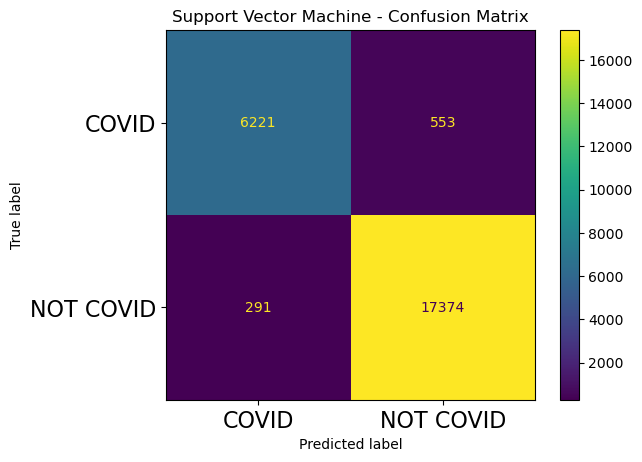

In [29]:
# Confusion Matrix for SVM
cm2 = ConfusionMatrixDisplay.from_estimator(best_model_svm, X_test, Y_test)

plt.title("Support Vector Machine - Confusion Matrix")
plt.xticks(range(2), ["COVID","NOT COVID"], fontsize=16)
plt.yticks(range(2), ["COVID","NOT COVID"], fontsize=16)
plt.show()

In [3]:
# Precision and Recall
precision_svm = calculate_precision(6221, 291)
recall_svm = calculate_recall(6221, 553)

print(f"Precision: {precision_svm}")
print(f"Recall: {recall_svm}")

Precision: 0.9553132678132679
Recall: 0.9183643342190729


In [36]:
### Gradient Boositin Model  with grid search the best hyperparameters ###
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gbm = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Create and fit the Gradient Boosting Model
gbm = GradientBoostingClassifier(random_state=42)
grid_search_gbm = GridSearchCV(gbm, param_grid_gbm, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_gbm.fit(xtrain, ytrain)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [37]:
# See the best parameters
best_params_gbm = grid_search_gbm.best_params_
print("Best Hyperparameters:", best_params_gbm)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}


In [42]:
# Best Gradient Boosting Model
best_model_gbm = grid_search_gbm.best_estimator_

# Make predictions on the test set
ypred = best_model_gbm.predict(X_test)

# Calculate and print Mean Squared Error and Accuracy
mse_gbm = mean_squared_error(Y_test, ypred)
accuracy_gbm = accuracy_score(Y_test, ypred)

print(f"Mean Squared Error: {mse_gbm}")
print(f"Accuracy: {accuracy_gbm}")

Mean Squared Error: 0.025901223454314826
Accuracy: 0.9740987765456852


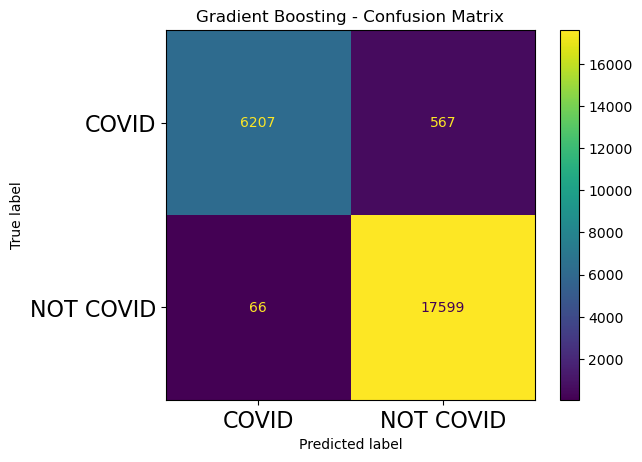

In [39]:
# Confusion Matrix for GBM
cm3 = ConfusionMatrixDisplay.from_estimator(best_model_gbm, X_test, Y_test)

plt.title("Gradient Boosting - Confusion Matrix")
plt.xticks(range(2), ["COVID","NOT COVID"], fontsize=16)
plt.yticks(range(2), ["COVID","NOT COVID"], fontsize=16)
plt.show()

In [4]:
# Precision and Recall
precision_gbm = calculate_precision(6207, 66)
recall_gbm = calculate_recall(6207, 567)

print(f"Precision: {precision_gbm}")
print(f"Recall: {recall_gbm}")

Precision: 0.989478718316595
Recall: 0.9162976085031


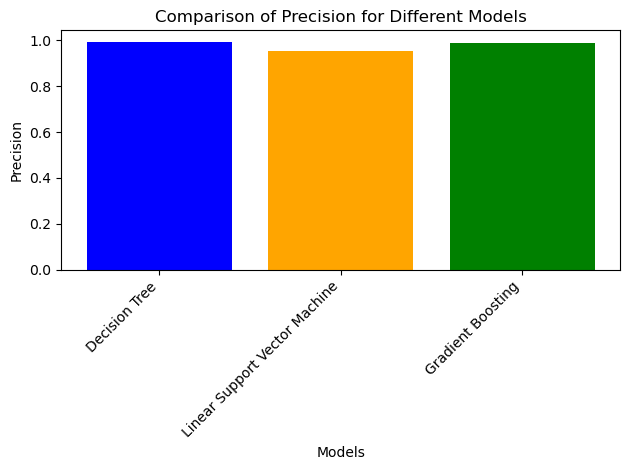

In [9]:
# Histogram of Precision for each model
models = ["Decision Tree", "Linear Support Vector Machine", "Gradient Boosting"]
mse_values = [precision_dtree, precision_svm, precision_gbm]

# Plotting the histogram
plt.bar(models, mse_values, color=['blue', 'orange', 'green'])
plt.xlabel('Models')
plt.ylabel('Precision')
plt.title('Comparison of Precision for Different Models')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()

plt.show()

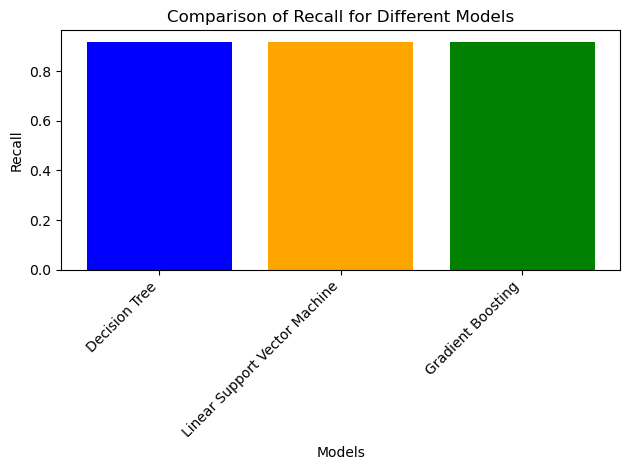

In [10]:
# Histogram of Recall for each model
models = ["Decision Tree", "Linear Support Vector Machine", "Gradient Boosting"]
mse_values = [recall_dtree, recall_svm, recall_gbm]

# Plotting the histogram
plt.bar(models, mse_values, color=['blue', 'orange', 'green'])
plt.xlabel('Models')
plt.ylabel('Recall')
plt.title('Comparison of Recall for Different Models')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()

plt.show()